Livrable 1

Ajout des dépendances

In [39]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pathlib

Chargement des données

In [57]:
#Paramètres

batch_size = 32
img_height = 180
img_width = 180
num_classes = 6

In [43]:
train_all_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./data',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    subset='training',
    seed=1,
    validation_split=0.2)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./data',
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    subset="validation",
    seed=1,
    validation_split=0.2)

data_dir = pathlib.Path().resolve()
list_ds = tf.data.Dataset.list_files(str(data_dir/'data/*/*'), shuffle=False)
image_count = len(list(data_dir.glob('data/*/*')))

list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# photo_dir =
# schematics_dir =
# sketch_dir =
# text_dir =

Found 41556 files belonging to 6 classes.
Using 33245 files for training.
Found 41556 files belonging to 6 classes.
Using 8311 files for validation.


In [29]:
class_names = train_all_ds.class_names

In [44]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [45]:
from tensorflow.python.data import AUTOTUNE

print(train_ds)

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

<SkipDataset shapes: (), types: tf.string>


In [46]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [47]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

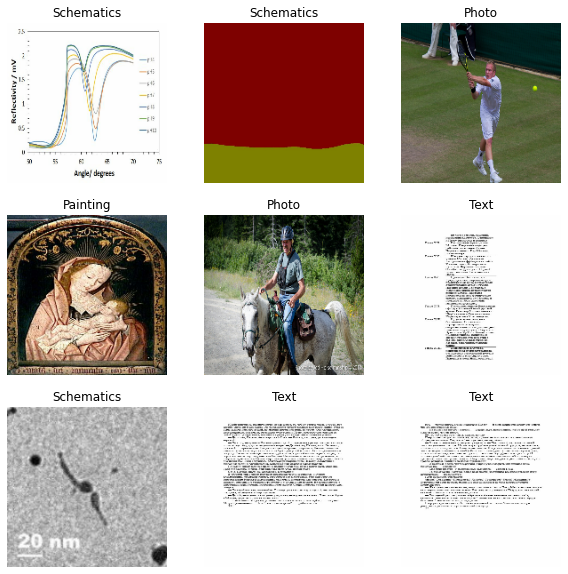

In [48]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [49]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Standardisation des données

In [50]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [51]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [54]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [55]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [58]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


InvalidArgumentError:  Received a label value of 5 which is outside the valid range of [0, 2).  Label values: 2 1 3 3 1 2 2 1 5 3 2 3 1 2 5 2 5 3 1 2 1 3 2 2 1 4 1 3 1 5 2 5
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\backend.py:5113)
]] [Op:__inference_train_function_2295]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\kevin\AppData\Local\Temp/ipykernel_22148/949346453.py", line 1, in <module>
>>>     model.fit(
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "C:\ProgramData\Anaconda3\envs\data\lib\site-packages\keras\backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Validation des données

In [ ]:

history = model.history #A COMPLETER

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()